#  Finding Optional Shared Streets

In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
import util
import seaborn as sns
import numpy as np
from matplotlib import cm, colors
import matplotlib.pyplot as plt

# Enable OSMNX cache
ox.config(use_cache=True)

## Objective

Selecting streets for conversion to a shared or open street is not trivial. 
Factors such as traffic impact and proper consideration to those affected need to be address.
This project aims to find and suggest roadways which can positively impact communities in Denver while minimizing impact on traffic.

## Data Sources

* OSMNX & Open Streets (“© OpenStreetMap contributors” via the Open Database License)
* City of Denver Open Data Catalog (CC BY 3.0)




### Load Denver Street Data

In [3]:
denver = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


### Add Data to Graphs

In [4]:
denver = util.add_speeds_to_graph(denver)
denver = util.drive_network_to_capacitated_network(denver)

### Focus on Particular Neighborhoods

In [5]:
neighborhoods = gpd.read_file(
    "../data/statistical_neighborhoods.gdb", driver="OpenFileGDB"
)

neighborhoods_of_focus = [
    "CBD",
    "Capitol Hill",
    "City Park West",
    "Five Points",
    "North Capitol Hill"
]

In [6]:
focus_poly = unary_union(neighborhoods[neighborhoods["NBHD_NAME"].isin(neighborhoods_of_focus)].geometry.values)
focus_network = ox.truncate.truncate_graph_polygon(denver, focus_poly)

## Choosing Candidate Streets

Before analyzing the impact on traffic, we select streets which a reasonable candidates based on factors such as
* Pedestrian Demand
* Equity Indices
* Park Access
* School Access
* and Transit Stops.

A more through discussion of the selection process can be found in the notebook [Best Neighborhood Streets](./BestNeighborhoodsStreets.ipynb).

### Load up candidate streets

In [7]:
candidate_streets = gpd.read_file("../processed/candidate_streets.shp")\
    .set_crs(epsg=util.CONFIG.base_crs)\
    .set_index(["u", "v", "key"])
candidate_streets.head()

,,,NCH_EVENTS,highway,oneway,length,maxspeed,ref,access,bridge,tunnel,index_righ,...,AVG_PDI_SC,AVG_PDI_10,PDI_EQUITY,SHAPE_Leng,SHAPE_Area,CPW_EVENTS,CH_EVENTS,FP_EVENTS,CBD_EVENTS,geometry
u,v,key,,,,,,,,,,,,,,,,,,,,,
176086235,4955447713,0,2.812963,secondary,1,105.643,30 mph,None,None,None,None,5,...,8.916667,9.950766,4.206085,0.040371,0.000096,NaN,NaN,NaN,NaN,"LINESTRING (-104.98110 39.74486, -104.98122 39..."
176097378,176086237,0,2.585185,tertiary,0,105.853,None,None,None,None,None,5,...,8.916667,9.950766,4.206085,0.040371,0.000096,NaN,NaN,NaN,NaN,"LINESTRING (-104.98233 39.74618, -104.98222 39..."
176086237,176097378,0,2.585185,tertiary,0,105.853,None,None,None,None,None,5,...,8.916667,9.950766,4.206085,0.040371,0.000096,NaN,NaN,NaN,NaN,"LINESTRING (-104.98109 39.74618, -104.98122 39..."
176086239,176088606,0,2.394444,tertiary,0,104.263,None,None,None,None,None,5,...,8.916667,9.950766,4.206085,0.040371,0.000096,NaN,NaN,NaN,NaN,"LINESTRING (-104.98109 39.74752, -104.98120 39..."
176088606,176086239,0,2.394444,tertiary,0,104.263,None,None,None,None,None,5,...,8.916667,9.950766,4.206085,0.040371,0.000096,NaN,NaN,NaN,NaN,"LINESTRING (-104.98231 39.74753, -104.98221 39..."


### Plot Candidate Streets

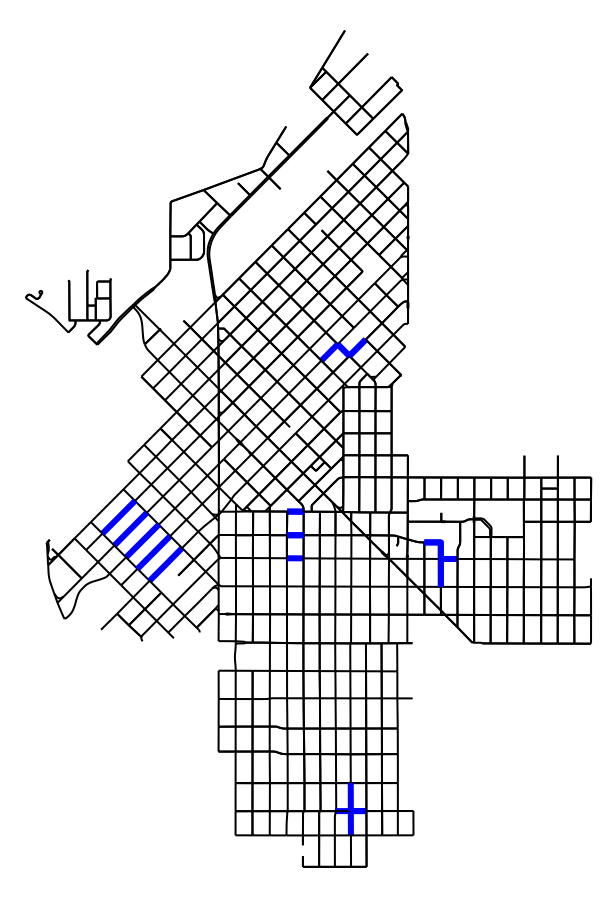

In [8]:
ec_candidate = ['blue' if edge in candidate_streets.index else 'black' for edge in focus_network.edges]
lw_candidate = [3 if edge in candidate_streets.index else 1 for edge in focus_network.edges]
fig, ax = ox.plot_graph(focus_network, node_size=1, edge_color=ec_candidate, node_alpha=0, bgcolor="white", edge_linewidth=lw_candidate)

### Areas of Concern for Traffic

<AxesSubplot:>

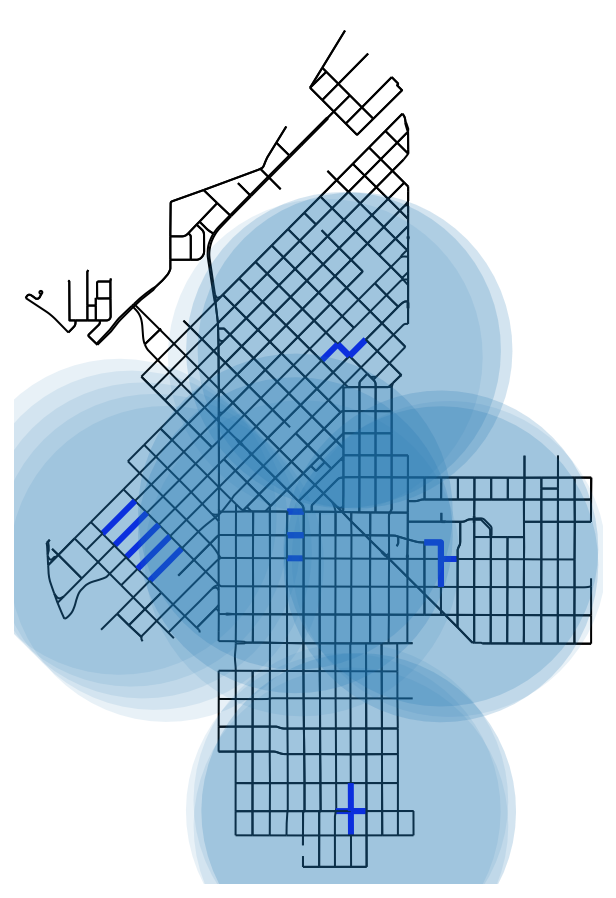

In [9]:
fig, ax = ox.plot_graph(focus_network, node_size=1, edge_color=ec_candidate, node_alpha=0, bgcolor="white", edge_linewidth=lw_candidate, show=False)
candidate_streets.to_crs(epsg=util.CONFIG.local_crs).geometry.representative_point().buffer(1000).to_crs(epsg=util.CONFIG.base_crs).plot(ax=ax, alpha=0.1)

In [10]:
def removal_impact(
    network: nx.DiGraph,
    arc: (int, int, int),
    radius: float, 
) -> float:
    
    net = nx.DiGraph(network)
    edges = ox.utils_graph.graph_to_gdfs(network, edges=True, nodes=False)
    area_of_interest = edges.loc[[arc]].to_crs(epsg=util.CONFIG.local_crs) \
        .geometry.representative_point().buffer(radius) \
        .to_crs(epsg=util.CONFIG.base_crs).iloc[0]
    
    net = nx.DiGraph(ox.truncate.truncate_graph_polygon(net, area_of_interest))
    
    unperturbed_flow_values, _unperturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    net.get_edge_data(arc[0], arc[1])["capacity"] = 0
    perturbed_flow_values, _perturbed_flows = util.all_pairs_max_flow(net, net.nodes)
    return {x: perturbed_flow_values[x] - unperturbed_flow_values[x] for x in perturbed_flow_values.keys()}

In [11]:
impacts = {}

for candidate in candidate_streets.index:
    impacts[candidate] = removal_impact(denver, candidate, 1000)

All pairs Max Flow: 100%|███████████████████████████████████████████| 2040/2040 [01:06<00:00, 30.54it/s]
All pairs Max Flow: 2137it [01:08, 31.13it/s]                                                           
All pairs Max Flow: 2137it [01:13, 29.25it/s]                                                           
All pairs Max Flow: 2137it [01:09, 30.82it/s]                                                           
All pairs Max Flow: 2137it [01:04, 32.99it/s]                                                           
All pairs Max Flow: 2253it [01:08, 32.74it/s]                                                           
All pairs Max Flow: 2253it [01:10, 31.80it/s]                                                           
All pairs Max Flow: 2253it [01:08, 32.78it/s]                                                           
All pairs Max Flow: 2253it [01:13, 30.55it/s]                                                           
All pairs Max Flow: 1646it [00:44, 37.23it/s]          

In [26]:
mean_impacts = {k: np.mean(list(v.values())) for (k, v) in impacts.items()}

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


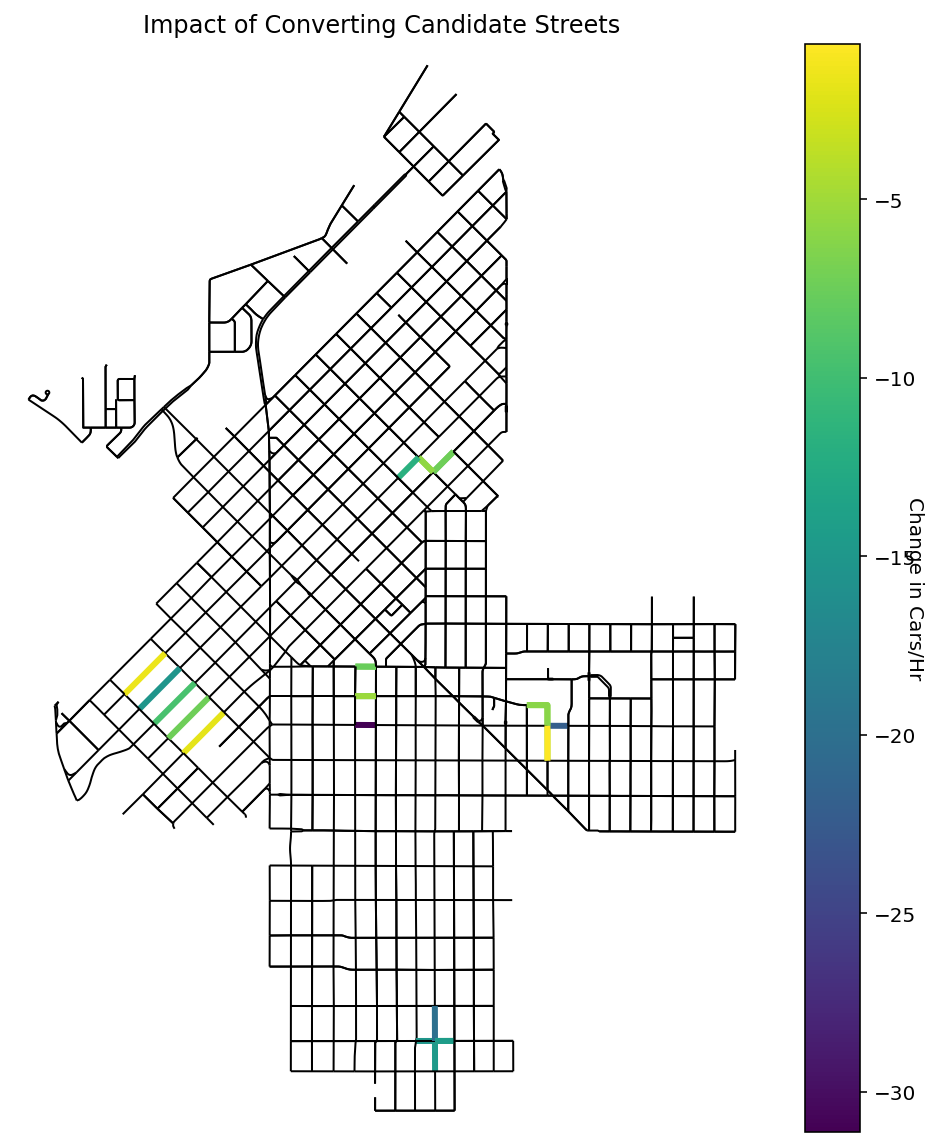

In [39]:
impact_norm = colors.Normalize()
impact_norm.autoscale(list(mean_impacts.values()))

ec_impacts = [cm.viridis(impact_norm(mean_impacts[edge])) if edge in mean_impacts else 'black' for edge in focus_network.edges]
lw_candidate = [3 if edge in candidate_streets.index else 1 for edge in focus_network.edges]
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')
ox.plot_graph(focus_network, node_size=1, edge_color=ec_impacts, node_alpha=0, bgcolor="white", edge_linewidth=lw_candidate, show=False, ax=ax)

cb = fig.colorbar(
    cm.ScalarMappable(norm=impact_norm, cmap=cm.viridis), ax=ax, orientation="vertical"
)
cb.ax.set_ylabel('Change in Cars/Hr', rotation=270)

ax.set_title("Impact of Converting Candidate Streets");